## Data preparation

In [1]:
# Imports and path configuration

from pathlib import Path
import json
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from urllib.parse import urlparse
from tldextract import extract
from collections import defaultdict, Counter

import seaborn as sns
from matplotlib.ticker import MaxNLocator

sns.color_palette("tab10")
pd.set_option('display.max_colwidth', None)

NOTEBOOK_DIR = Path.cwd()
CRAWL_ROOT = NOTEBOOK_DIR.parents[0]
RESOURCES_ROOT = NOTEBOOK_DIR.parents[1] / "res"

SITE_LIST_PATH = RESOURCES_ROOT / "site_list.csv"
ENTITIES_JSON = RESOURCES_ROOT / "entities.json"
SERVICES_JSON = RESOURCES_ROOT / "services.json"

print("NOTEBOOK_DIR =", NOTEBOOK_DIR)
print("CRAWL_ROOT   =", CRAWL_ROOT)
print("PROJECT_ROOT =", RESOURCES_ROOT)

CRAWL_DIRS = {
    "Crawl-Accept": CRAWL_ROOT / "crawl_data_accept",
    "Crawl-Reject": CRAWL_ROOT / "crawl_data_reject",
    "Crawl-Block":  CRAWL_ROOT / "crawl_data_block",
}

TARGET_CATEGORIES = {
    "Advertising",
    "Analytics",
    "Social",
    "FingerprintingInvasive",
    "FingerprintingGeneral",
}

NOTEBOOK_DIR = D:\Documents\Studijos\IV_1_kursas\Online Tracking and Security\project2\otp-assignement2\src\analysis
CRAWL_ROOT   = D:\Documents\Studijos\IV_1_kursas\Online Tracking and Security\project2\otp-assignement2\src
PROJECT_ROOT = D:\Documents\Studijos\IV_1_kursas\Online Tracking and Security\project2\otp-assignement2\res


In [2]:
# Utility functions 
def load_har(path: Path) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_site_country_map(path: Path) -> dict:
    domain_map = {}
    with open(path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            d = row.get("domain") or row.get("site") or row.get("url")
            c = row.get("country") or row.get("cc") or "unknown"
            if d:
                domain_map[d.strip()] = c.strip().lower()
    return domain_map


def get_etld_plus_one(url_or_domain: str) -> str:
    # If its url extract hostname first
    if url_or_domain.startswith(('http://', 'https://', '//')):
        try:
            url_or_domain = urlparse(url_or_domain).hostname or url_or_domain
        except Exception:
            pass
    
    # Extract eTLD+1
    parts = extract(url_or_domain)
    return f"{parts.domain}.{parts.suffix}" if parts.domain and parts.suffix else url_or_domain

def load_entities_map(path: Path) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    root = data.get("entities", {})
    mapping = {}
    
    for entity_name, meta in root.items():
        if not isinstance(meta, dict):
            continue

        # for 1st and 13th questions mapping properies and resources to the same enitity is ok
        display = meta.get("displayName", entity_name)
        for p in meta.get("properties", []) or []:
            etld1 = get_etld_plus_one(p)
            if etld1:
                mapping[etld1] = display
        for r in meta.get("resources", []) or []:
            etld1 = get_etld_plus_one(r)
            if etld1:
                mapping[etld1] = display
    return mapping

TARGET_CATEGORIES = {
    "Advertising",
    "Analytics",
    "Social",
    "FingerprintingInvasive",
    "FingerprintingGeneral",
}

def load_services_categories(path: Path) -> dict[str, set[str]]:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    root = data.get("categories", data)
    domain_categories: dict[str, set[str]] = {}

    for cat_name, cat_data in root.items():
        
        if cat_name not in TARGET_CATEGORIES:
            continue
        if not isinstance(cat_data, list):
            continue

        for service_obj in cat_data:
            if not isinstance(service_obj, dict):
                continue
            for service_name, service_data in service_obj.items():
                if not isinstance(service_data, dict):
                    continue
                # keys are domains
                for dom in service_data.keys():
                    reg = get_etld_plus_one(dom) or dom
                    domain_categories.setdefault(reg, set()).add(cat_name)

    return domain_categories

def has_meaningful_response(entry) -> bool:
    resp = entry.get("response", {}) or {}
    status = int(resp.get("status", 0) or 0)
    if status <= 0:
        return False
    headers = resp.get("headers", [])
    content = resp.get("content", {})
    return bool(headers or content)

def find_js_cookies(har_path: Path, first_party: str) -> list[dict]:
    """
    Track all cookies seen in Set-Cookie headers of resps vs
    all cookies seen in Cookie headers of reqs.
    JS cookies = request-only
    """
    har = load_har(har_path)
    entries = har.get("log", {}).get("entries", [])
    
    server_set_cookies = set()  # Cookies from Set-Cookie headers
    request_cookies = {}        # {cookie_name: domain_it_was_sent_to}
    
    for entry in entries:
        # Track Set-Cookie from responses
        response = entry.get("response", {})
        for cookie in response.get("cookies", []):
            server_set_cookies.add(cookie.get("name"))
        
        # Track Cookie from requests
        request = entry.get("request", {})
        url = request.get("url", "")
        req_domain = get_etld_plus_one(url)
        
        for cookie in request.get("cookies", []):
            name = cookie.get("name")
            if name and name not in server_set_cookies:
                request_cookies[name] = req_domain
    
    js_cookies = []
    for name, domain in request_cookies.items():
        js_cookies.append({
            'cookie_name': name,
            'website': first_party,
            'cookie_domain': domain
        })
    
    return js_cookies

def analyze_visit(har_path: Path, crawl_type: str, country: str, first_party: str,
                  services_categories: dict,
                  entities_map: dict) -> tuple[dict, list[dict]]:

    def process_third_party(tp_domain, third_party_dict, entity_disconnect_categories):
        if tp_domain not in third_party_dict:
            # Create new object if domain doesn't exist
            third_party_dict.append({
                'third_party_domain': tp_domain,
                'nr_distinct_websites': 1,
                'disconnect_categories': entity_disconnect_categories
            })
        else:
            # Increment count if domain already exists
            third_party_dict[tp_domain]['nr_distinct_websites'] += 1
        
    har = load_har(har_path)
    log = har.get("log", {}) or {}
    entries = log.get("entries", []) or []

    num_requests = 0
    num_third = 0
    third_domains = set()
    third_entities = set()
    advertising = False
    analytics = False
    server_ips = set()

    third_party_list = []

    for e in entries:
        if not has_meaningful_response(e):
            continue

        num_requests += 1

        req = e.get("request", {}) or {}
        resp = e.get("response", {}) or {}
        url = req.get("url", "")
        req_domain = get_etld_plus_one(url)
                
        # Third-party detection + entity checking
        if req_domain and first_party and req_domain != first_party:
 
            req_entity = entities_map.get(req_domain)
            first_party_entity = entities_map.get(first_party)
            
            is_same_entity = (req_entity and first_party_entity and 
                            req_entity == first_party_entity)

            # if third party came from different entity, so it is actually third-party
            if not is_same_entity:
                num_third += 1
                third_domains.add(req_domain)

                # Check categories
                entity_disconnect_categories = services_categories.get(req_domain, set())
                if "Advertising" in entity_disconnect_categories:
                    advertising = True
                if "Analytics" in entity_disconnect_categories:
                    analytics = True

                # Append flat record for this third-party
                third_party_list.append({
                    'crawl_type': crawl_type,
                    'site': first_party,
                    'third_party_domain': req_domain
                })
                # Track entity
                if req_entity and req_entity not in third_entities:
                    third_entities.add(req_entity)
                           
        ### end of third-party detection

        # Server IPs
        ip = resp.get("serverIPAddress") or e.get("serverIPAddress")
        if ip:
            server_ips.add(ip)

    return (
        {
            'crawl_type': crawl_type,
            'country': country,
            'site': first_party,
            "country": country,
            "num_requests": num_requests,
            "num_third_party_requests": num_third,
            "num_distinct_third_party_domains": len(third_domains),
            "num_distinct_entities": len(third_entities),
            "has_advertising": advertising,
            "has_analytics": analytics,
            "num_distinct_server_ips": len(server_ips),
        },
        third_party_list)

In [3]:
site_country = load_site_country_map(SITE_LIST_PATH)
entities_map = load_entities_map(ENTITIES_JSON)
services_categories = load_services_categories(SERVICES_JSON)

In [4]:
records = []
third_party_records = []
x = 0
for crawl_type, folder in CRAWL_DIRS.items():
    print(f"Total {len(list(folder.glob("*.har")))} HAR files in {folder}")
    for har_path in folder.glob("*.har"):
        site = har_path.stem
        country = site_country.get(site, "unknown")
        
        (rec, third_party_recs) = analyze_visit(har_path, crawl_type, country, site, services_categories, entities_map)
        
        records.append(rec)
        third_party_records.extend(third_party_recs)
df = pd.DataFrame(records)
# for the task 7
df_third_party = pd.DataFrame(third_party_records)

Total 40 HAR files in D:\Documents\Studijos\IV_1_kursas\Online Tracking and Security\project2\otp-assignement2\src\crawl_data_accept
Total 40 HAR files in D:\Documents\Studijos\IV_1_kursas\Online Tracking and Security\project2\otp-assignement2\src\crawl_data_reject
Total 40 HAR files in D:\Documents\Studijos\IV_1_kursas\Online Tracking and Security\project2\otp-assignement2\src\crawl_data_block


## Task 1

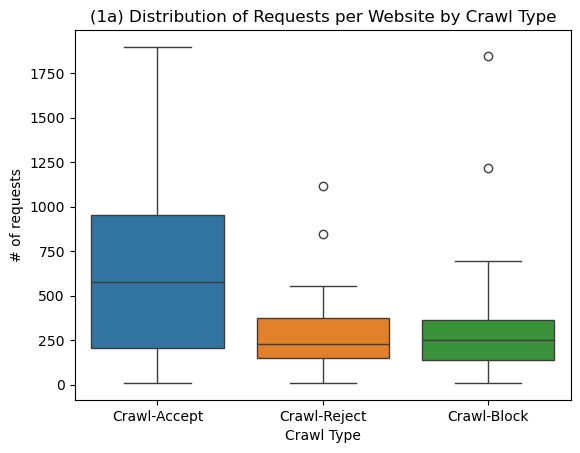

In [5]:
# a. Number of requests per website 
ax = sns.boxplot(x='crawl_type', y="num_requests", data = df, hue='crawl_type', legend=False)
ax.set_title("(1a) Distribution of Requests per Website by Crawl Type")
ax.set(xlabel='Crawl Type', ylabel='# of requests')
plt.show()

In [6]:
df.head()

,crawl_type,country,site,num_requests,num_third_party_requests,num_distinct_third_party_domains,num_distinct_entities,has_advertising,has_analytics,num_distinct_server_ips
0,Crawl-Accept,nl,ad.nl,755,608,59,20,True,True,0
1,Crawl-Accept,us,apnews.com,1256,1148,139,89,True,True,0
2,Crawl-Accept,us,axios.com,183,57,18,8,True,True,0
3,Crawl-Accept,uk,bbc.co.uk,311,212,10,7,True,True,0
4,Crawl-Accept,us,bloomberg.com,22,20,7,3,False,False,0


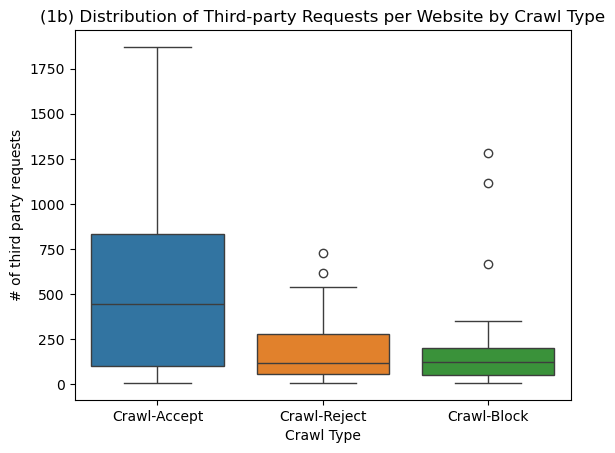

In [7]:
# b. Number of third-party requests per website
ax = sns.boxplot(x='crawl_type', y="num_third_party_requests", data = df, hue='crawl_type', legend=False)
ax.set_title("(1b) Distribution of Third-party Requests per Website by Crawl Type")
ax.set(xlabel='Crawl Type', ylabel='# of third party requests')
plt.show()

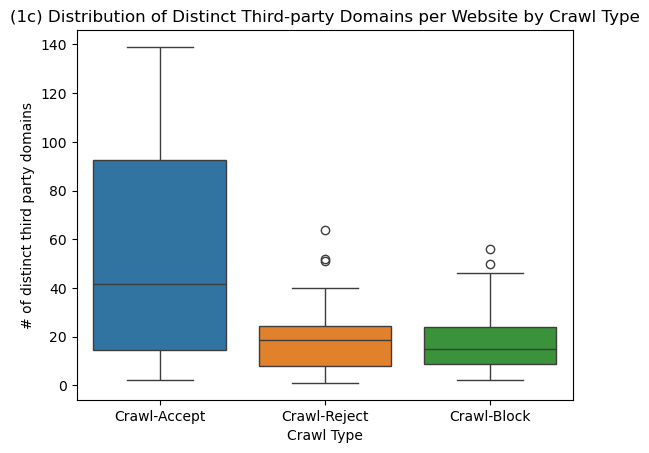

In [8]:
# c. Number of distinct third-party domains per website
ax = sns.boxplot(x='crawl_type', y="num_distinct_third_party_domains", data = df, hue='crawl_type', legend=False)
ax.set_title("(1c) Distribution of Distinct Third-party Domains per Website by Crawl Type")
ax.set(xlabel='Crawl Type', ylabel='# of distinct third party domains')
plt.show()

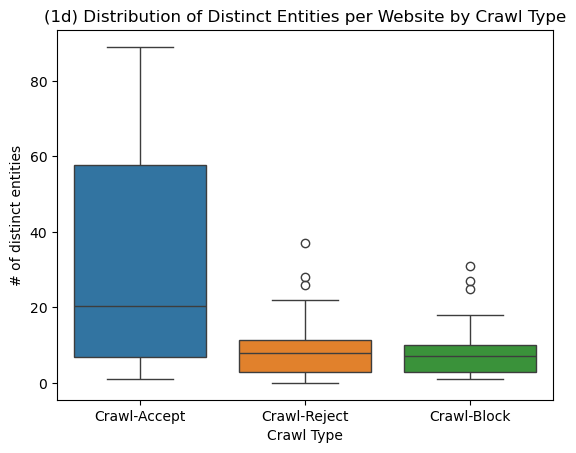

In [9]:
# d. Number of distinct entities per website, using Disconnect’s entities list 
ax = sns.boxplot(x='crawl_type', y="num_distinct_entities", data = df, hue='crawl_type', legend=False)
ax.set_title("(1d) Distribution of Distinct Entities per Website by Crawl Type")
ax.set(xlabel='Crawl Type', ylabel='# of distinct entities')
plt.show()

## Task 2

In [10]:
df.head()

,crawl_type,country,site,num_requests,num_third_party_requests,num_distinct_third_party_domains,num_distinct_entities,has_advertising,has_analytics,num_distinct_server_ips
0,Crawl-Accept,nl,ad.nl,755,608,59,20,True,True,0
1,Crawl-Accept,us,apnews.com,1256,1148,139,89,True,True,0
2,Crawl-Accept,us,axios.com,183,57,18,8,True,True,0
3,Crawl-Accept,uk,bbc.co.uk,311,212,10,7,True,True,0
4,Crawl-Accept,us,bloomberg.com,22,20,7,3,False,False,0


In [11]:
metrics = [
    "num_requests",
    "num_third_party_requests",
    "num_distinct_third_party_domains",
    "num_distinct_entities",
]

df.groupby("crawl_type")[metrics].agg(["min", "median", "max"])

num_requests              num_third_party_requests               \
                      min median   max                      min median   max   
crawl_type                                                                     
Crawl-Accept           10  576.5  1897                        8  444.0  1870   
Crawl-Block            10  251.0  1845                        8  122.0  1282   
Crawl-Reject           10  229.0  1114                        8  117.5   728   

             num_distinct_third_party_domains              \
                                          min median  max   
crawl_type                                                  
Crawl-Accept                                2   41.5  139   
Crawl-Block                                 2   15.0   56   
Crawl-Reject                                1   18.5   64   

             num_distinct_entities             
                               min median max  
crawl_type                                     
Crawl-Accept                     1   20.5  89  
Crawl-Block                      1    7.0  31  
Crawl-Reject                     0    8.0  37

## Task 3

In [12]:
counts = df.groupby("crawl_type")[["has_advertising", "has_analytics"]].sum()
counts

,has_advertising,has_analytics
crawl_type,,
Crawl-Accept,33,35
Crawl-Block,32,30
Crawl-Reject,29,28


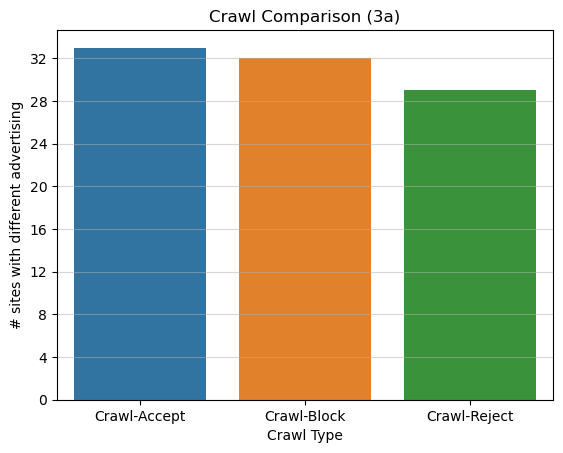

In [13]:
# task 3. a)
ax = sns.barplot(x='crawl_type', y='has_advertising', data=counts, hue='crawl_type')
ax.set_title("Crawl Comparison (3a)")
ax.set(xlabel='Crawl Type', ylabel='# sites with different advertising')

# draw lines
ax.grid(True, axis='y', linestyle='-', alpha=0.5)
# force showing only natural numbers (integers)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

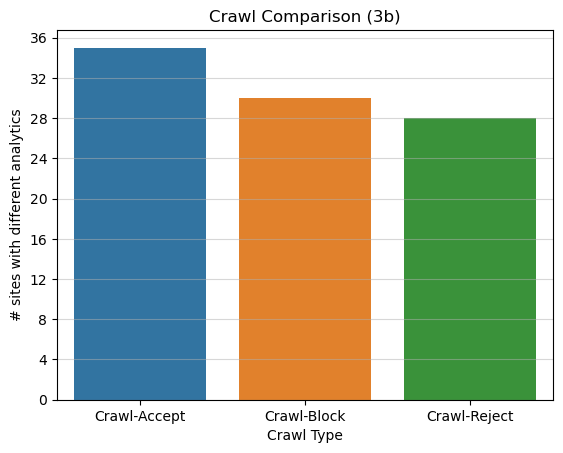

In [14]:
# task 3. b)
ax = sns.barplot(x='crawl_type', y='has_analytics', data=counts, hue='crawl_type')
ax.set_title("Crawl Comparison (3b)")
ax.set(xlabel='Crawl Type', ylabel='# sites with different analytics')

# draw lines
ax.grid(True, axis='y', linestyle='-', alpha=0.5)
# force showing only natural numbers (integers)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

## Task 4

In [15]:
metrics = [
    "num_requests",
    "num_third_party_requests",
    "num_distinct_third_party_domains",
    "num_distinct_entities",
]
df_accept = df[df.crawl_type == 'Crawl-Accept']
df_accept['continent'] = 'Europe'
df_accept.loc[df_accept['country'] == 'us', 'continent'] = 'US'

df_rez = df_accept.groupby("continent")[metrics].agg(["min", "median", "max"])

C:\Users\edvar\AppData\Local\Temp\ipykernel_26640\3716918987.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accept['continent'] = 'Europe'


In [16]:
df_rez.rename(index={'US':"US News Sites", 'Europe': "European News Sites"}, inplace = True)
df_rez

num_requests              num_third_party_requests         \
                             min median   max                      min median   
continent                                                                       
European News Sites           93  798.0  1897                       12  636.5   
US News Sites                 10  469.0  1530                        8  311.5   

                          num_distinct_third_party_domains              \
                      max                              min median  max   
continent                                                                
European News Sites  1870                                3   66.5  137   
US News Sites        1429                                2   32.0  139   

                    num_distinct_entities             
                                      min median max  
continent                                             
European News Sites                     1   24.5  89  
US News Sites                           1   16.5  89

## Task 5

In [17]:
counts = df_accept.groupby("continent")[["has_advertising", "has_analytics"]].sum()

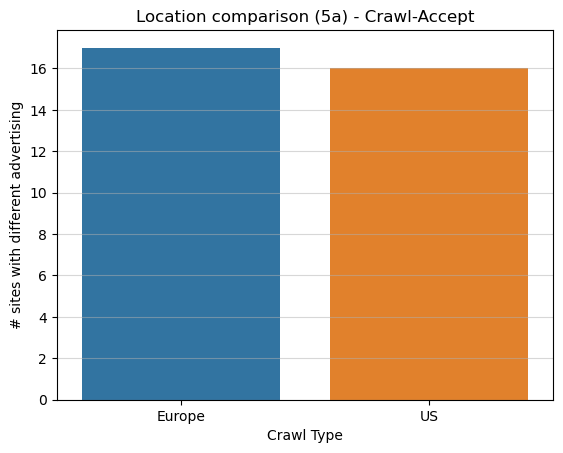

In [18]:
# 5a) advertising: compare US news websites with European news websites
ax = sns.barplot(x='continent', y='has_advertising', data=counts, hue='continent')
ax.set_title("Location comparison (5a) - Crawl-Accept")
ax.set(xlabel='Crawl Type', ylabel='# sites with different advertising')

# draw lines
ax.grid(True, axis='y', linestyle='-', alpha=0.5)
# force showing only natural numbers (integers)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

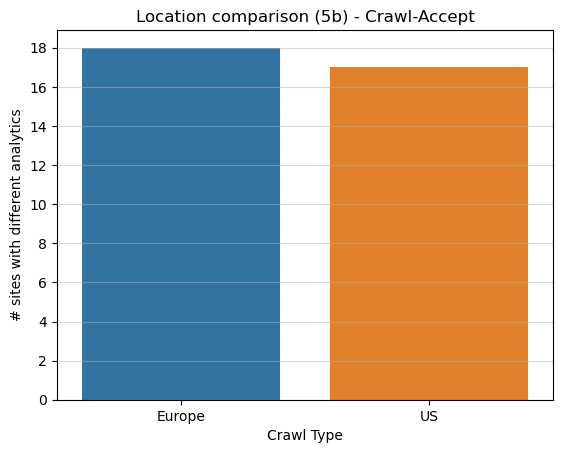

In [19]:
# 5 b) analytics: compare US news websites with European news websites
ax = sns.barplot(x='continent', y='has_analytics', data=counts, hue='continent')
ax.set_title("Location comparison (5b) - Crawl-Accept")
ax.set(xlabel='Crawl Type', ylabel='# sites with different analytics')

# draw lines
ax.grid(True, axis='y', linestyle='-', alpha=0.5)
# force showing only natural numbers (integers)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

## Task 6

In [20]:
def find_js_cookies(har_path: Path, first_party: str) -> list[dict]:
    """
    Find cookies likely set by JavaScript.
    
    METHOD:
    Process entries chronologically. For each domain, track which cookies
    were set via Set-Cookie. If a cookie appears in a request but was never set
    by Set-Cookie for that specific earlier, it's likely JS-set.
    1. Track all cookies set via Set-Cookie response headers (server-side)
    2. Track all cookies sent in Cookie request headers (requests to server)
    3. Cookies appearing in requests but NEVER in Set-Cookie are JS-set

    RATIONALE:
    - Server-side cookies appear in Set-Cookie response headers
    - JS-set cookies (document.cookie=...) only appear in Cookie request headers
    - By tracking server-set cookies per domain, we identify client-side cookies
    """
    har = load_har(har_path)
    entries = har.get("log", {}).get("entries", [])
    
    # Track server-set cookies per domain: {domain: {cookie_names}}
    server_cookies_by_domain = {}
    js_cookies = []
    seen_js_cookies = set()  # Avoid duplicates
    
    for entry in entries:
        # First, check if this response sets any cookies
        response = entry.get("response", {})
        resp_headers = response.get("headers", [])
        req_url = entry.get("request", {}).get("url", "")
        resp_domain = get_etld_plus_one(req_url)
        
        for header in resp_headers:
            if header.get("name", "").lower() == "set-cookie":
                cookie_str = header.get("value", "")
                if "=" in cookie_str:
                    cookie_name = cookie_str.split("=")[0].strip()
                    if resp_domain:
                        server_cookies_by_domain.setdefault(resp_domain, set()).add(cookie_name)
        
        # Then, check cookies in the request
        request = entry.get("request", {})
        req_headers = request.get("headers", [])
        req_domain = get_etld_plus_one(req_url)
        
        for header in req_headers:
            if header.get("name", "").lower() == "cookie":
                cookie_str = header.get("value", "")
                for cookie_pair in cookie_str.split(";"):
                    if "=" in cookie_pair:
                        cookie_name = cookie_pair.split("=")[0].strip()
                        
                        # Check if this cookie was ever set by server for THIS domain
                        domain_server_cookies = server_cookies_by_domain.get(req_domain, set())
                        
                        if cookie_name and cookie_name not in domain_server_cookies:
                            # This is likely a JS-set cookie
                            key = (cookie_name, first_party, req_domain)
                            if key not in seen_js_cookies:
                                seen_js_cookies.add(key)
                                js_cookies.append({
                                    'cookie_name': cookie_name,
                                    'website': first_party,
                                    'cookie_domain': req_domain
                                })
    if js_cookies:
        print(site + ": " + str(len(js_cookies)) +  " JS cookies found")
    return js_cookies

js_cookie_records = []

for har_path in CRAWL_DIRS['Crawl-Accept'].glob("*.har"):
    site = har_path.stem
    js_cookies = find_js_cookies(har_path, site)
    js_cookie_records.extend(js_cookies)

df_js_cookies = pd.DataFrame(js_cookie_records)

print(f"Found {len(df_js_cookies)} potential JavaScript-set cookies")

ad.nl: 31 JS cookies found
apnews.com: 142 JS cookies found
axios.com: 15 JS cookies found
bbc.co.uk: 5 JS cookies found
bloomberg.com: 5 JS cookies found
businessinsider.com: 55 JS cookies found
buzzfeed.com: 83 JS cookies found
cbsnews.com: 41 JS cookies found
cnbc.com: 117 JS cookies found
cnn.com: 108 JS cookies found
corriere.it: 185 JS cookies found
dailymail.co.uk: 132 JS cookies found
dw.com: 10 JS cookies found
foxnews.com: 20 JS cookies found
france24.com: 7 JS cookies found
gazzetta.it: 163 JS cookies found
huffpost.com: 122 JS cookies found
lefigaro.fr: 3 JS cookies found
lemonde.fr: 5 JS cookies found
libero.it: 99 JS cookies found
msn.com: 28 JS cookies found
msnbc.com: 26 JS cookies found
n-tv.de: 109 JS cookies found
nbcnews.com: 113 JS cookies found
newsweek.com: 172 JS cookies found
nltimes.nl: 7 JS cookies found
nos.nl: 11 JS cookies found
nu.nl: 22 JS cookies found
nypost.com: 136 JS cookies found
nytimes.com: 17 JS cookies found
repubblica.it: 95 JS cookies found
r

In [21]:
df_js_cookies.head()

,cookie_name,website,cookie_domain
0,_sp_ses.e23f,ad.nl,dpgmedia.nl
1,_sp_id.e23f,ad.nl,dpgmedia.nl
2,gtm_temptation_template_id,ad.nl,ad.nl
3,tcf20_purposes,ad.nl,ad.nl
4,_vwo_uuid_v2,ad.nl,ad.nl


In [22]:
output_csv = NOTEBOOK_DIR / "task6_js_cookies.csv"
df_js_cookies.to_csv(output_csv, index=False)

## Task 7

In [23]:
df_third_party_rez = df_third_party.groupby(['crawl_type', 'third_party_domain'])\
    .agg(nr_distinct_websites=('site', 'nunique')).reset_index()
df_third_party_rez['Disconnect categories'] = df_third_party_rez['third_party_domain'].apply(
    lambda domain: ', '.join(sorted(services_categories.get(domain, set()))) 
                   if services_categories.get(domain, set()) 
                   else 'NA'
)

In [24]:
df_third_party_rez

,crawl_type,third_party_domain,nr_distinct_websites,Disconnect categories
0,Crawl-Accept,1bliq.io,1,NA
1,Crawl-Accept,1rx.io,13,NA
2,Crawl-Accept,2cnt.net,2,NA
3,Crawl-Accept,2mdn.net,18,NA
4,Crawl-Accept,2o7.net,1,NA
...,...,...,...,...
1400,Crawl-Reject,yahoo.com,1,"Advertising, Analytics, Social"
1401,Crawl-Reject,youtube.com,1,NA
1402,Crawl-Reject,zemanta.com,2,NA
1403,Crawl-Reject,zephr.com,2,NA


In [25]:
df_third_party_rez.rename(columns={
    'third_party_domain':"Third-party domain",
    'nr_distinct_websites':"Number of distinct websites"}, inplace=True)
df_third_party_rez[df_third_party_rez['crawl_type'] == "Crawl-Accept"]\
        .sort_values("Number of distinct websites", ascending=False).head(10).reset_index(drop=True).iloc[:,1:]

,Third-party domain,Number of distinct websites,Disconnect categories
0,googlesyndication.com,29,NA
1,google.com,28,"Advertising, Analytics, FingerprintingGeneral, Social"
2,doubleclick.net,28,NA
3,amazon-adsystem.com,27,NA
4,googleapis.com,25,NA
5,adtrafficquality.google,25,NA
6,criteo.com,25,Advertising
7,googletagmanager.com,23,NA
8,adsrvr.org,22,NA
9,bidswitch.net,22,NA


In [26]:
df_third_party_rez[df_third_party_rez['crawl_type'] == "Crawl-Block"]\
        .sort_values("Number of distinct websites", ascending=False).head(10).reset_index(drop=True).iloc[:,1:]

,Third-party domain,Number of distinct websites,Disconnect categories
0,googletagmanager.com,22,NA
1,google.com,21,"Advertising, Analytics, FingerprintingGeneral, Social"
2,doubleclick.net,19,NA
3,googleapis.com,18,NA
4,googlesyndication.com,15,NA
5,amazon-adsystem.com,14,NA
6,gstatic.com,12,NA
7,scorecardresearch.com,11,NA
8,jsdelivr.net,9,NA
9,cookielaw.org,9,NA


In [27]:
df_third_party_rez[df_third_party_rez['crawl_type'] == "Crawl-Reject"]\
        .sort_values("Number of distinct websites", ascending=False).head(10).reset_index(drop=True).iloc[:,1:]

,Third-party domain,Number of distinct websites,Disconnect categories
0,googletagmanager.com,23,NA
1,doubleclick.net,22,NA
2,googlesyndication.com,20,NA
3,googleapis.com,20,NA
4,google.com,18,"Advertising, Analytics, FingerprintingGeneral, Social"
5,gstatic.com,15,NA
6,amazon-adsystem.com,14,NA
7,scorecardresearch.com,11,NA
8,google-analytics.com,11,NA
9,adtrafficquality.google,10,NA


## Task 8

In [28]:
sort_column = 'Number of distinct third-party domains'
df_target = df[['crawl_type', 'site', 'country', 'num_distinct_third_party_domains']].rename(columns=
            {'site':'Website', 'country': 'Country code', 'num_distinct_third_party_domains':sort_column})
df_accept = df_target[df_target.crawl_type == 'Crawl-Accept'].sort_values(sort_column, ascending = False).head(10).reset_index(drop=True).iloc[:,1:]
df_reject = df_target[df_target.crawl_type == 'Crawl-Reject'].sort_values(sort_column, ascending = False).head(10).reset_index(drop=True).iloc[:,1:]
df_block = df_target[df_target.crawl_type == 'Crawl-Block'].sort_values(sort_column, ascending = False).head(10).reset_index(drop=True).iloc[:,1:]

In [29]:
df_accept

,Website,Country code,Number of distinct third-party domains
0,apnews.com,us,139
1,libero.it,it,137
2,gazzetta.it,it,133
3,the-sun.com,uk,129
4,corriere.it,it,128
5,nypost.com,us,126
6,newsweek.com,us,119
7,dailymail.co.uk,uk,107
8,telegraaf.nl,nl,106
9,huffpost.com,us,95


In [30]:
df_reject

,Website,Country code,Number of distinct third-party domains
0,nbcnews.com,us,64
1,newsweek.com,us,52
2,apnews.com,us,51
3,businessinsider.com,us,40
4,nypost.com,us,35
5,gazzetta.it,it,34
6,bbc.co.uk,uk,28
7,corriere.it,it,27
8,cnbc.com,us,26
9,telegraaf.nl,nl,26


In [31]:
df_block

,Website,Country code,Number of distinct third-party domains
0,nbcnews.com,us,56
1,newsweek.com,us,50
2,apnews.com,us,46
3,ad.nl,nl,36
4,nypost.com,us,35
5,gazzetta.it,it,35
6,telegraaf.nl,nl,26
7,businessinsider.com,us,25
8,the-sun.com,uk,25
9,repubblica.it,it,24


# Task 9

In [32]:

ip_metric_col = "num_distinct_server_ips"  

sort_column_q9 = "Number of distinct server IPs"

df_q9 = (
    df[["site", "crawl_type", "country", ip_metric_col]]
    .rename(columns={
        "site": "Website",
        "country": "Country code",
        ip_metric_col: sort_column_q9,
    })
    .copy()
)

crawl_type_map = {
    "Crawl-Accept": "Accept",
    "Crawl-Reject": "Reject",
    "Crawl-Block": "Block",
}
df_q9["Crawl type"] = df_q9["crawl_type"].map(crawl_type_map)


df_q9 = df_q9[["Website", "Crawl type", "Country code", sort_column_q9]]


df_q9_top10 = (
    df_q9
    .sort_values(sort_column_q9, ascending=False)
    .head(10)
    .reset_index(drop=True)
)

display(df_q9_top10.style.set_caption(
    "Top 10 visits (website, crawl_type) by number of distinct server IPs"
))


,Website,Crawl type,Country code,Number of distinct server IPs
0,ad.nl,Accept,nl,0
1,apnews.com,Accept,us,0
2,axios.com,Accept,us,0
3,bbc.co.uk,Accept,uk,0
4,bloomberg.com,Accept,us,0
5,businessinsider.com,Accept,us,0
6,buzzfeed.com,Accept,us,0
7,cbsnews.com,Accept,us,0
8,cnbc.com,Accept,us,0
9,cnn.com,Accept,us,0


# Task 10

In [33]:

def get_disabled_permissions_for_visit(site: str, crawl_type: str) -> set[str]:

    har_dir = CRAWL_DIRS[crawl_type]
    har_path = har_dir / f"{site}.har"

    if not har_path.exists():
        return set()

    try:
        with open(har_path, "r", encoding="utf-8") as f:
            har = json.load(f)
    except Exception:
        return set()

    disabled = set()
    entries = har.get("log", {}).get("entries", [])

    for entry in entries:
        resp = entry.get("response", {})
        headers = resp.get("headers", [])

        for h in headers:
            name = h.get("name", "").lower()
            if name not in {"permissions-policy", "permission-policy"}:
                continue

            value = h.get("value", "")

            for part in value.split(","):
                part = part.strip()
                if "=" not in part:
                    continue
                perm, val = part.split("=", 1)
                perm = perm.strip()
                val = val.strip()

                if val.replace(" ", "") == "()":
                    disabled.add(perm)

    return disabled

disabled_by_crawl: dict[str, dict[str, set[str]]] = {
    "Crawl-Accept": defaultdict(set),
    "Crawl-Reject": defaultdict(set),
    "Crawl-Block":  defaultdict(set),
}

for row in df[["site", "crawl_type"]].drop_duplicates().itertuples(index=False):
    site = row.site
    crawl_type = row.crawl_type
    disabled_perms = get_disabled_permissions_for_visit(site, crawl_type)

    for perm in disabled_perms:
        disabled_by_crawl[crawl_type][perm].add(site)

global_counts = Counter()
for crawl_type, perms_dict in disabled_by_crawl.items():
    for perm, sites in perms_dict.items():
        global_counts[perm] += len(sites)

top5_perms = [perm for perm, _ in global_counts.most_common(5)]
top5_perms


['camera', 'geolocation', 'microphone', 'midi', 'interest-cohort']

In [34]:
rows = []

for perm in top5_perms:
    row = {"Permission": perm}

    for crawl_type in ["Crawl-Accept", "Crawl-Reject", "Crawl-Block"]:
        sites_set = disabled_by_crawl[crawl_type].get(perm, set())
        count = len(sites_set)
        row[crawl_type] = f"{perm}: {count}"

    rows.append(row)

table_q10 = pd.DataFrame(rows).set_index("Permission")

display(
    table_q10.style.set_caption(
        "Number of distinct websites where this permission was disabled (permission=())"
    )
)


,Crawl-Accept,Crawl-Reject,Crawl-Block
Permission,,,
camera,camera: 15,camera: 8,camera: 8
geolocation,geolocation: 15,geolocation: 8,geolocation: 8
microphone,microphone: 15,microphone: 8,microphone: 8
midi,midi: 14,midi: 8,midi: 8
interest-cohort,interest-cohort: 13,interest-cohort: 8,interest-cohort: 8


# Task 11

In [35]:
DEFAULT_POLICIES = {"no-referrer-when-downgrade"}
def get_referrer_policies_for_visit(site: str, crawl_type: str) -> set[str]:

    har_dir = CRAWL_DIRS[crawl_type]
    har_path = har_dir / f"{site}.har"

    if not har_path.exists():
        return set()

    try:
        with open(har_path, "r", encoding="utf-8") as f:
            har = json.load(f)
    except Exception:
        return set()

    policies = set()
    entries = har.get("log", {}).get("entries", [])

    for entry in entries:
        resp = entry.get("response", {})
        headers = resp.get("headers", [])

        for h in headers:
            name = h.get("name", "").lower()
            if name != "referrer-policy":
                continue

            value = h.get("value", "").strip().lower()
            if value and value not in DEFAULT_POLICIES:
                policies.add(value)

    return policies


refpol_by_crawl: dict[str, dict[str, set[str]]] = {
    "Crawl-Accept": defaultdict(set),
    "Crawl-Reject": defaultdict(set),
    "Crawl-Block":  defaultdict(set),
}

for row in df[["site", "crawl_type"]].drop_duplicates().itertuples(index=False):
    site = row.site
    crawl_type = row.crawl_type
    policies = get_referrer_policies_for_visit(site, crawl_type)

    for pol in policies:
        refpol_by_crawl[crawl_type][pol].add(site)


In [36]:
policy_counts_by_crawl = {}
for crawl_type, pol_dict in refpol_by_crawl.items():
    policy_counts_by_crawl[crawl_type] = Counter(
        {pol: len(sites) for pol, sites in pol_dict.items()}
    )

for crawl_type in policy_counts_by_crawl:
    policy_counts_by_crawl[crawl_type] = Counter(
        dict(policy_counts_by_crawl[crawl_type].most_common())
    )

max_len = max(len(c) for c in policy_counts_by_crawl.values())

rows = []
crawl_cols = ["Crawl-Accept", "Crawl-Reject", "Crawl-Block"]

for i in range(max_len):
    row = {}
    for crawl_type in crawl_cols:
        items = list(policy_counts_by_crawl[crawl_type].items())
        if i < len(items):
            pol, count = items[i]
            row[crawl_type] = f"{pol}: {count}"
        else:
            row[crawl_type] = ""
    rows.append(row)

table_q11 = pd.DataFrame(rows)

display(
    table_q11.style.set_caption(
        "Number of distinct websites where this Referrer Policy was observed"
    )
)


,Crawl-Accept,Crawl-Reject,Crawl-Block
0,strict-origin-when-cross-origin: 22,strict-origin-when-cross-origin: 16,strict-origin-when-cross-origin: 21
1,same-origin: 9,same-origin: 6,same-origin: 5
2,no-referrer: 8,no-referrer: 4,no-referrer: 4
3,unsafe-url: 3,unsafe-url: 3,unsafe-url: 3
4,origin: 2,strict-origin: 1,strict-origin: 1
5,strict-origin: 1,"origin-when-cross-origin, strict-origin-when-cross-origin: 1","origin-when-cross-origin, strict-origin-when-cross-origin: 1"
6,"origin-when-cross-origin, strict-origin-when-cross-origin: 1",,


# Task 12

In [37]:
def get_accept_ch_for_visit(site: str, crawl_type: str) -> set[str]:
    
    har_dir = CRAWL_DIRS[crawl_type]
    har_path = har_dir / f"{site}.har"

    if not har_path.exists():
        return set()

    try:
        with open(har_path, "r", encoding="utf-8") as f:
            har = json.load(f)
    except Exception:
        return set()

    hints = set()
    entries = har.get("log", {}).get("entries", [])

    for entry in entries:
        resp = entry.get("response", {})
        headers = resp.get("headers", [])

        for h in headers:
            name = h.get("name", "").lower()
            if name != "accept-ch":
                continue

            value = h.get("value", "")
            for part in value.split(","):
                hint = part.strip()
                if hint:
                    hints.add(hint)

    return hints

acceptch_by_crawl: dict[str, dict[str, set[str]]] = {
    "Crawl-Accept": defaultdict(set),
    "Crawl-Reject": defaultdict(set),
    "Crawl-Block":  defaultdict(set),
}

for row in df[["site", "crawl_type"]].drop_duplicates().itertuples(index=False):
    site = row.site
    crawl_type = row.crawl_type

    hints = get_accept_ch_for_visit(site, crawl_type)
    for hint in hints:
        acceptch_by_crawl[crawl_type][hint].add(site)


In [38]:
top3_by_crawl = {}

for crawl_type in ["Crawl-Accept", "Crawl-Reject", "Crawl-Block"]:
    counter = Counter({
        hint: len(sites)
        for hint, sites in acceptch_by_crawl[crawl_type].items()
    })

    top3 = counter.most_common(3)
    top3_by_crawl[crawl_type] = top3

rows = []
max_len = max(len(v) for v in top3_by_crawl.values())

for i in range(max_len):
    row = {}
    for crawl_type in ["Crawl-Accept", "Crawl-Reject", "Crawl-Block"]:
        items = top3_by_crawl[crawl_type]
        if i < len(items):
            hint, count = items[i]
            row[crawl_type] = f"{hint}: {count}"
        else:
            row[crawl_type] = ""
    rows.append(row)

table_q12 = pd.DataFrame(rows)

display(
    table_q12.style.set_caption(
        "Number of distinct websites where this Client Hint was observed (Accept-CH)"
    )
)


,Crawl-Accept,Crawl-Reject,Crawl-Block
0,Sec-CH-UA-Arch: 29,Sec-CH-UA-Arch: 21,Sec-CH-UA-Arch: 14
1,Sec-CH-UA-Model: 29,Sec-CH-UA-Model: 21,Sec-CH-UA-Model: 14
2,Sec-CH-UA-Platform: 28,Sec-CH-UA-Full-Version-List: 20,Sec-CH-UA-Full-Version-List: 13


# Task 13

In [39]:
with open(ENTITIES_JSON, "r", encoding="utf-8") as f:
    entities_raw = json.load(f)

entities_section = entities_raw.get("entities", {})

domain_to_entity = {}

for entity_name, info in entities_section.items():
    if not isinstance(info, dict):
        continue

    domains = set(info.get("properties", []) + info.get("resources", []))

    for host in domains:
        ext = extract(host)
        if not ext.domain or not ext.suffix:
            continue
        root = f"{ext.domain}.{ext.suffix}"
        domain_to_entity[root] = entity_name

print("Loaded Disconnect entities (unique eTLD+1):", len(domain_to_entity))

def etld1(url: str) -> str | None:
    if not url:
        return None
    host = urlparse(url).hostname
    if not host:
        return None
    ext = extract(host)
    if not ext.domain or not ext.suffix:
        return None
    return f"{ext.domain}.{ext.suffix}"


Loaded Disconnect entities (unique eTLD+1): 6922


In [40]:
def extract_cross_entity_redirects_for_visit(site: str, crawl_type: str):
    har_path = CRAWL_DIRS[crawl_type] / f"{site}.har"
    if not har_path.exists():
        return []

    try:
        with open(har_path, "r", encoding="utf-8") as f:
            har = json.load(f)
    except Exception:
        return []

    entries = har.get("log", {}).get("entries", [])
    rows = []

    for entry in entries:
        req = entry.get("request", {})
        resp = entry.get("response", {})

        status = resp.get("status", 0)
        if not (300 <= status < 400):
            continue

        location = None
        for h in resp.get("headers", []):
            if h.get("name", "").lower() == "location":
                location = h.get("value")
                break
        if not location:
            continue

        src_domain = etld1(req.get("url", ""))
        tgt_domain = etld1(location)
        if not src_domain or not tgt_domain:
            continue

        src_entity = domain_to_entity.get(src_domain)
        tgt_entity = domain_to_entity.get(tgt_domain)

        if not src_entity or not tgt_entity:
            continue
        if src_entity == tgt_entity:
            continue

        rows.append(
            {
                "Source domain": src_domain,
                "Source entity": src_entity,
                "Target domain": tgt_domain,
                "Target entity": tgt_entity,
                "Website": site,
            }
        )

    return rows


tables_q13 = {}

for crawl_type in ["Crawl-Accept", "Crawl-Reject", "Crawl-Block"]:
    rows = []

    for row in df[["site", "crawl_type"]].drop_duplicates().itertuples(index=False):
        if row.crawl_type != crawl_type:
            continue
        rows.extend(extract_cross_entity_redirects_for_visit(row.site, crawl_type))

    df_crawl = pd.DataFrame(rows)

    if not df_crawl.empty:
        df_crawl = df_crawl[
            ["Source domain", "Source entity", "Target domain", "Target entity", "Website"]
        ].sort_values(
            ["Source domain", "Target domain", "Website"]
        ).reset_index(drop=True)

    tables_q13[crawl_type] = df_crawl

    print(f"\n Cross-entity redirects – {crawl_type} ")
    display(df_crawl)



 Cross-entity redirects – Crawl-Accept 


,Source domain,Source entity,Target domain,Target entity,Website
0,1rx.io,Nexxen,adsrvr.org,The Trade Desk,apnews.com
1,1rx.io,Nexxen,adsrvr.org,The Trade Desk,apnews.com
2,1rx.io,Nexxen,adsrvr.org,The Trade Desk,libero.it
3,1rx.io,Nexxen,adsrvr.org,The Trade Desk,nbcnews.com
4,1rx.io,Nexxen,adsrvr.org,The Trade Desk,newsweek.com
...,...,...,...,...,...
1035,zemanta.com,Outbrain,rubiconproject.com,Magnite,gazzetta.it
1036,zemanta.com,Outbrain,rubiconproject.com,Magnite,the-sun.com
1037,zemanta.com,Outbrain,seedtag.com,SeedTag,corriere.it
1038,zemanta.com,Outbrain,seedtag.com,SeedTag,telegraaf.nl



 Cross-entity redirects – Crawl-Reject 


,Source domain,Source entity,Target domain,Target entity,Website
0,admanmedia.com,AdmanMedia,criteo.com,Criteo,nbcnews.com
1,casalemedia.com,IndexExchange,doubleclick.net,Google,nbcnews.com
2,doubleclick.net,Google,criteo.com,Criteo,nbcnews.com
3,doubleclick.net,Google,demdex.net,Adobe,nbcnews.com
4,doubleclick.net,Google,doubleverify.com,DoubleVerify,bbc.co.uk
5,doubleclick.net,Google,doubleverify.com,DoubleVerify,bbc.co.uk
6,doubleclick.net,Google,doubleverify.com,DoubleVerify,bbc.co.uk
7,doubleclick.net,Google,doubleverify.com,DoubleVerify,bbc.co.uk
8,doubleclick.net,Google,doubleverify.com,DoubleVerify,bbc.co.uk
9,doubleclick.net,Google,doubleverify.com,DoubleVerify,bbc.co.uk



 Cross-entity redirects – Crawl-Block 


,Source domain,Source entity,Target domain,Target entity,Website
0,doubleclick.net,Google,adnxs.com,Microsoft,ad.nl
1,doubleclick.net,Google,demdex.net,Adobe,nbcnews.com
2,doubleclick.net,Google,doubleverify.com,DoubleVerify,ad.nl
3,yahoo.com,Yahoo!,360yield.com,Improve Digital,libero.it


# Task 14

In [42]:
!pip install dnspython

In [43]:
import dns.resolver
from dns.exception import DNSException

with open(SERVICES_JSON, "r", encoding="utf-8") as f:
    services_raw = json.load(f)

categories_section = services_raw.get("categories", {})

blocklist_root_to_cats: dict[str, set[str]] = {}

for cat_name, vendors in categories_section.items():
    if not isinstance(vendors, list):
        continue

    for vendor_block in vendors:
        if not isinstance(vendor_block, dict):
            continue
        for vendor_name, vendor_data in vendor_block.items():
            if not isinstance(vendor_data, dict):
                continue
            for homepage, domains in vendor_data.items():
                if not isinstance(domains, list):
                    continue
                for dom in domains:
                    dom = dom.lstrip("*.").lower()
                    ext = extract(dom)
                    if not ext.domain or not ext.suffix:
                        continue
                    root = f"{ext.domain}.{ext.suffix}"
                    blocklist_root_to_cats.setdefault(root, set()).add(cat_name)

print("Blocklist roots loaded:", len(blocklist_root_to_cats))


def etld1_from_url(url: str) -> str | None:
    if not url:
        return None
    host = urlparse(url).hostname
    if not host:
        return None
    ext = extract(host)
    if not ext.domain or not ext.suffix:
        return None
    return f"{ext.domain}.{ext.suffix}"


def hostname_from_url(url: str) -> str | None:
    if not url:
        return None
    return urlparse(url).hostname


def get_first_party_subdomains_for_visit(site: str, crawl_type: str) -> set[str]:
    har_path = CRAWL_DIRS[crawl_type] / f"{site}.har"
    if not har_path.exists():
        return set()

    try:
        with open(har_path, "r", encoding="utf-8") as f:
            har = json.load(f)
    except Exception:
        return set()

    entries = har.get("log", {}).get("entries", [])
    site_root = etld1_from_url(f"https://{site}")

    hosts = set()
    for entry in entries:
        req = entry.get("request", {})
        url = req.get("url", "")
        host = hostname_from_url(url)
        if not host:
            continue
        root = etld1_from_url(url)
        if root and root == site_root:
            hosts.add(host.lower())

    return hosts


def resolve_cname(hostname: str) -> str | None:
    try:
        answers = dns.resolver.resolve(hostname, "CNAME")
    except DNSException:
        return None
    except Exception:
        return None

    for r in answers:
        target = str(r.target).rstrip(".").lower()
        return target
    return None


Blocklist roots loaded: 4088


In [44]:

rows_q14 = []

for row in df[["site", "crawl_type"]].drop_duplicates().itertuples(index=False):
    site = row.site
    crawl_type = row.crawl_type

    first_party_hosts = get_first_party_subdomains_for_visit(site, crawl_type)

    for host in first_party_hosts:
        cname = resolve_cname(host)
        if not cname:
            continue

        cname_root = etld1_from_url(f"https://{cname}")
        if not cname_root:
            continue

        cats = blocklist_root_to_cats.get(cname_root, set())
        if not cats:
            continue  # pas un domaine de la blocklist

        cname_entity = domain_to_entity.get(cname_root, "Unknown")

        rows_q14.append(
            {
                "Crawl type": crawl_type,
                "First-party subdomain": host,
                "CNAME record": cname,
                "CNAME entity": cname_entity,
                "Disconnect categories": ", ".join(sorted(cats)),
            }
        )

df_q14 = pd.DataFrame(rows_q14)

if df_q14.empty:
    print("No first-party CNAMEs pointing to Disconnect entities were observed.")
else:
    for crawl_type in ["Crawl-Accept", "Crawl-Reject", "Crawl-Block"]:
        sub = df_q14[df_q14["Crawl type"] == crawl_type].copy()
        if sub.empty:
            print(f"\n=== {crawl_type}: no matching CNAME trackers ===")
            continue

        sub = sub[
            [
                "First-party subdomain",
                "CNAME record",
                "CNAME entity",
                "Disconnect categories",
            ]
        ].drop_duplicates().reset_index(drop=True)

        print(f"\n=== CNAME-based tracking – {crawl_type} ===")
        display(sub)



=== CNAME-based tracking – Crawl-Accept ===


,First-party subdomain,CNAME record,CNAME entity,Disconnect categories
0,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
1,sli.businessinsider.com,d1otvstqxnw37u.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
2,sli.cbsnews.com,d15kivt7fp1kel.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
3,zephr-templates.cnbc.com,d3qj5wuhimh3ra.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
4,smetrics.cnn.com,cnn.com.102.122.2o7.net,Adobe,"Advertising, Email, FingerprintingGeneral"
5,api-weather-be.corriere.it,d32dpitu2anj7x.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
6,api-video.corriere.it,d24p96brdjmljd.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
7,video.corriere.it,d1p15w45f27aqk.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
8,forumcorriere.corriere.it,d3mixdy9px9a4c.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
9,idsync.dailymail.co.uk,k8s-default-publicht-93f8ef5393-1909601027.eu-west-2.elb.amazonaws.com,Amazon,Content



=== CNAME-based tracking – Crawl-Reject ===


,First-party subdomain,CNAME record,CNAME entity,Disconnect categories
0,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
1,sli.businessinsider.com,d1otvstqxnw37u.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
2,zephr-templates.cnbc.com,d3qj5wuhimh3ra.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
3,video.corriere.it,d1p15w45f27aqk.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
4,forumcorriere.corriere.it,d3mixdy9px9a4c.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
5,247preview.foxnews.com,fnc247preview.foxnews.com.akamaized.net,Take-Two,"Analytics, FingerprintingGeneral, FingerprintingInvasive"
6,smetrics.foxnews.com,foxnews.com.ssl.d1.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
7,static2.abbonamenti.gazzetta.it,d23yhnnqssijqq.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
8,api2-mtc.gazzetta.it,d1fm7fuuekry8j.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
9,api-video.gazzetta.it,d9kqvgumogq80.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"



=== CNAME-based tracking – Crawl-Block ===


,First-party subdomain,CNAME record,CNAME entity,Disconnect categories
0,permutive.businessinsider.com,atcvt1h5rg5p.customer.permutive.app,Permutive,Advertising
1,zephr-templates.cnbc.com,d3qj5wuhimh3ra.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
2,smetrics.cnn.com,cnn.com.102.122.2o7.net,Adobe,"Advertising, Email, FingerprintingGeneral"
3,api-video.corriere.it,d24p96brdjmljd.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
4,video.corriere.it,d1p15w45f27aqk.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
5,forumcorriere.corriere.it,d3mixdy9px9a4c.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
6,247preview.foxnews.com,fnc247preview.foxnews.com.akamaized.net,Take-Two,"Analytics, FingerprintingGeneral, FingerprintingInvasive"
7,smetrics.foxnews.com,foxnews.com.ssl.d1.sc.omtrdc.net,Adobe,"Advertising, Email, FingerprintingGeneral"
8,searchapiservice2.gazzetta.it,d2arvzuswg4o6w.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
9,static2.abbonamenti.gazzetta.it,d23yhnnqssijqq.cloudfront.net,dz7188oz6lnyb.cloudfront.net,"Analytics, Content, FingerprintingInvasive"
